In [135]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import math
from datetime import datetime
from datetime import date
from functools import reduce
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt 
from datetime import timedelta
from sklearn.externals.six import StringIO
from IPython.display import Image, display
from sklearn.tree import export_graphviz
import pydotplus

In [147]:
#auxiliary helper functions (not model based)
def getData(file, cols): 
    "Takes in an HTML DOM and returns a pandas dataframes"
    with open(file) as f:
        soup = BeautifulSoup( f, 'html.parser' )
        text = str(soup.find_all('script')[5])

        first = 0
        results = []
        while first != -1: 
            beginning = text.find( "[new Date", first )
            ending = text.find( "]", beginning)
            dataText = text[beginning+1:ending] 
            row = dataText.split(",")
            results.append( row )
            first = ending
        results = results[:-1]
        for i,row in enumerate(results): 
            date = row[0]
            date = date[:-1]
            junkIdx = date.find( "(" )
            row[0] = date[junkIdx+1:]
            results[i] = row

        df = pd.DataFrame(results, columns=cols )

        df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '"%Y/%m/%d"') )
        #covert to float 
        numerical_columns = cols[1:]
        for num_col in numerical_columns: 
            df[num_col] = df[num_col].apply(lambda x: float(0) if x == "null" else math.log( float(x) ) )
        return df
      
def MSE( predictions, actual ): 
    diffs = predictions - actual 
    u = 0 
    for elem in diffs: 
        u += ( elem ** 2 )
    return u / len(predictions)

def myplot(actual, predictions):
    plt.plot(actual, label = "actual")
    plt.plot(predictions, label = "predict")
    axes = plt.gca()
    plt.legend(loc = "upper right")
    plt.show()
    
    
def cleanData():
    x_Values = [ ("difficulty.html", ["Date", "Bitcoin Difficulty", "Ethereum Difficulty", "Ripple Difficulty"]), 
    ( "hashrate.html", ["Date", "Bitcoin Hashrate", "Ethereum Hashrate", "Ripple Hashrate"]), 
    ( "miningProb.html", ["Date", "Bitcoin Mining Prob", "Ethereum Mining Prob", "Ripple Mining Prob"]), 
    ( "averageTransactionValue.html", ["Date", "Bitcoin Avg. Transaction Value", "Ethereum Avg. Transaction Value", "Ripple Avg. Transaction Value"]), 
    ( "transactionsData.html", ["Date", "Bitcoin No. of Transactions", "Ethereum No. of Transactions", "Ripple No. of Transactions"]), 
    ( "averageTransactionFee.html", ["Date", "Bitcoin Avg. Transaction Fee", "Ethereum Avg. Transaction Fee", "Ripple Avg. Transaction Fee"])]
    y_Values = [ ("marketCapitalization.html", ["Date", "Bitcoin Market Cap", "Ethereum Market Cap", "Ripple Market Cap"] ) ]
    
    dfs = []
    for filename, columns in x_Values: 
        result = getData( filename, columns )
        dfs.append( result )

    for filename, columns in y_Values: 
        y_df = getData( filename, columns )
        y_df.set_index( "Date", inplace = True )

    #merging all features into one df 
    dataset = dfs[0]
    for i in range(1, len(dfs)): 
        dataset = dataset.merge(dfs[i], on='Date', how="outer")

    return dataset, y_df

******************************BTC Lin Reg ******************************
                            OLS Regression Results                            
Dep. Variable:     Bitcoin Market Cap   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.016e+06
Date:                Mon, 10 Dec 2018   Prob (F-statistic):               0.00
Time:                        20:31:23   Log-Likelihood:                -404.66
No. Observations:                2725   AIC:                             815.3
Df Residuals:                    2722   BIC:                             833.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------

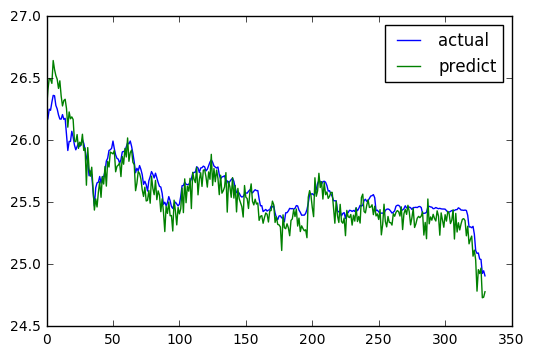

******************************ETH Lin Reg ******************************
                             OLS Regression Results                            
Dep. Variable:     Ethereum Market Cap   R-squared:                       0.998
Model:                             OLS   Adj. R-squared:                  0.998
Method:                  Least Squares   F-statistic:                 4.528e+05
Date:                 Mon, 10 Dec 2018   Prob (F-statistic):               0.00
Time:                         20:31:23   Log-Likelihood:                -1791.8
No. Observations:                 2725   AIC:                             3592.
Df Residuals:                     2721   BIC:                             3615.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------

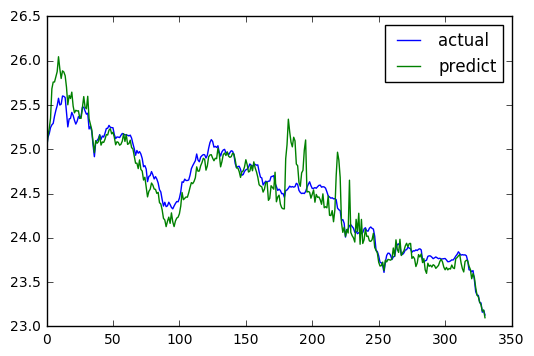

In [146]:
#Linreg models
def runBTCLinReg( dataset, y_df ): 
    print("******************************BTC Lin Reg ******************************")
    #creating a dataframe with all Bitcoin data, got rid of Hashrate and # of transactions
    btc_columns = ["Date", "Bitcoin Difficulty", "Bitcoin Hashrate", "Bitcoin Mining Prob",]
    btc_df = dataset[ btc_columns ].fillna(value = 0)
    btc_df.set_index("Date", inplace = True) 
    y_btc_df = y_df[ ["Bitcoin Market Cap"] ] 

    #Training data set
    trainingX_btc_df = btc_df.loc[:date(year=2017,month=12,day=31)]
    trainingY_btc_df = y_btc_df.loc[:date(year=2017,month=12,day=31)]
    train = pd.concat([trainingX_btc_df, trainingY_btc_df], axis=1, join = "inner")
    
    #Run linear regression on training set and print summary
    linreg = smf.OLS(train['Bitcoin Market Cap'], train[train.columns.tolist()[:-1]]).fit()
    print(linreg.summary())

    #Create prediction data set 
    predictX_btc_df = btc_df.loc[date(year=2018, month=1, day =1):]
    predictY_btc_df = y_btc_df.loc[date(year=2018,month=1,day=1):date(year=2018,month=11,day=27)]
    predictData = pd.concat([predictX_btc_df, predictY_btc_df], axis=1, join = "inner")

    #Use linreg to test on prediction set 
    predictions = linreg.predict( predictData[ predictData.columns.tolist()[:-1] ] )
    
    #Print additional info and graph predicted values with actual values
    actual = predictY_btc_df["Bitcoin Market Cap"].values.tolist()
    print( "R-squared of BTC running linreg is %f" % r2_score( predictions, actual ) )
    print( "MSE of BTC running linreg is %f" % MSE( predictions, actual ) )
    print("\n")
    myplot(actual, predictions)
    
def runETHLinReg( dataset, y_df ):
    print("******************************ETH Lin Reg ******************************")
    #creating a dataframe with all Ethereum data, got rid of Hashrate and # of transactions
    eth_columns = ["Date", "Ethereum Hashrate", "Ethereum Mining Prob", "Ethereum No. of Transactions","Ethereum Avg. Transaction Fee"]
    eth_df = dataset[ eth_columns ].fillna(value = 0)
    eth_df.set_index("Date", inplace = True) 
    y_eth_df = y_df[ ["Ethereum Market Cap"] ]

    #Training data set
    trainingX_eth_df = eth_df.loc[:date(year=2017,month=12,day=31)]
    trainingY_eth_df = y_eth_df.loc[:date(year=2017,month=12,day=31)]
    train = pd.concat([trainingX_eth_df, trainingY_eth_df], axis=1, join = "inner")
    
    #Run linear regression on training set and print summary
    linreg = smf.OLS(train['Ethereum Market Cap'], train[train.columns.tolist()[:-1]]).fit()
    print(linreg.summary())
    
    #Create prediction data set 
    predictX_eth_df = eth_df.loc[date(year=2018, month=1, day =1):]
    predictY_eth_df = y_eth_df.loc[date(year=2018,month=1,day=1):date(year=2018,month=11,day=27)]
    predictData = pd.concat([predictX_eth_df, predictY_eth_df], axis=1, join = "inner")

    #Use linreg to test on prediction set 
    predictions = linreg.predict( predictData[ predictData.columns.tolist()[:-1] ] )

    #Print additional info and graph predicted values with actual values    
    actual = predictY_eth_df["Ethereum Market Cap"].values.tolist()
    print("Ethereum Features: %s" % ', '.join(eth_columns))
    print( "R-squared of ETH running linreg is %f" % r2_score( predictions, actual ) )
    print( "MSE of ETH running linreg is %f" % MSE( predictions, actual ) )
    print( "\n" )
    myplot(actual, predictions)
    
def runLinReg(): 
    dataset, y_df = cleanData() 
    runBTCLinReg( dataset, y_df )
    runETHLinReg( dataset, y_df )
    
runLinReg()   

******************************BTC Dec Tree ******************************
The fit of this BTC data with a Decision Trees model is 0.999998
Bitcoin range 0.054907
R-squared of BTC running Decision Trees is -1.794196
MSE of BTC running Decision Trees is 0.000107




/Users/simritdhinsa/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


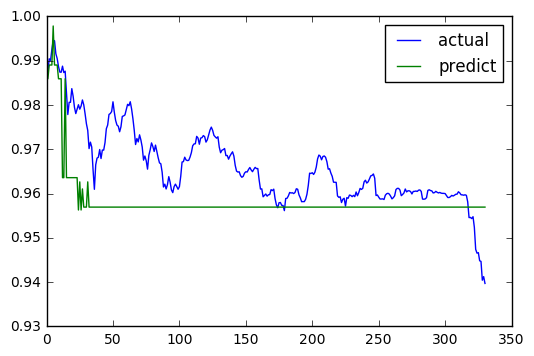

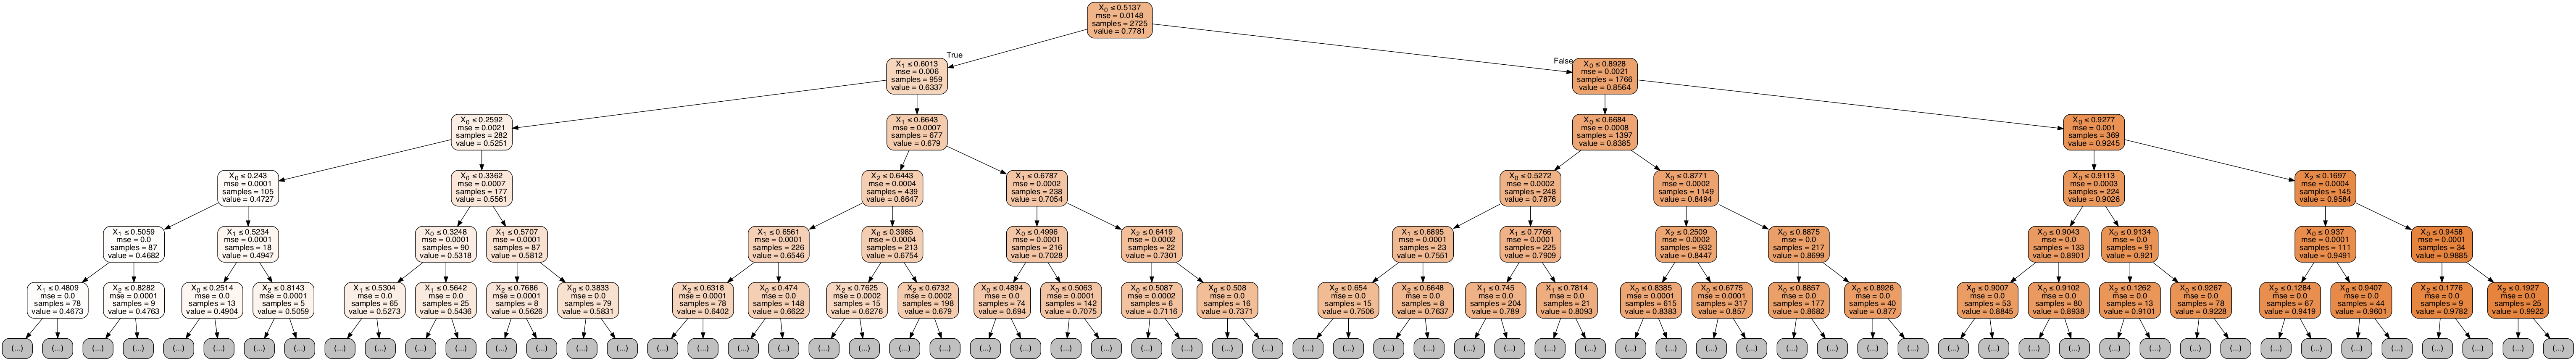

******************************ETH Dec Tree ******************************
The fit of this ETH data with a Decision Trees model is 0.988425
R-squared of ETH running Decision Trees is -2.439173
MSE of ETH running Decision Trees is 0.000322




/Users/simritdhinsa/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


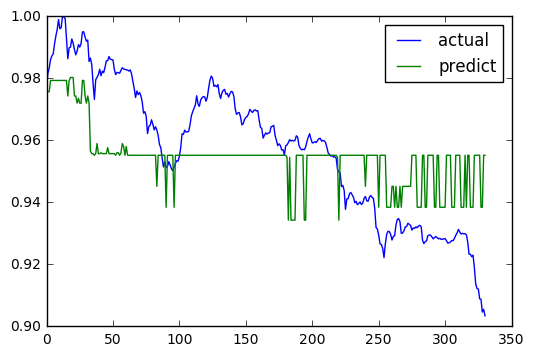

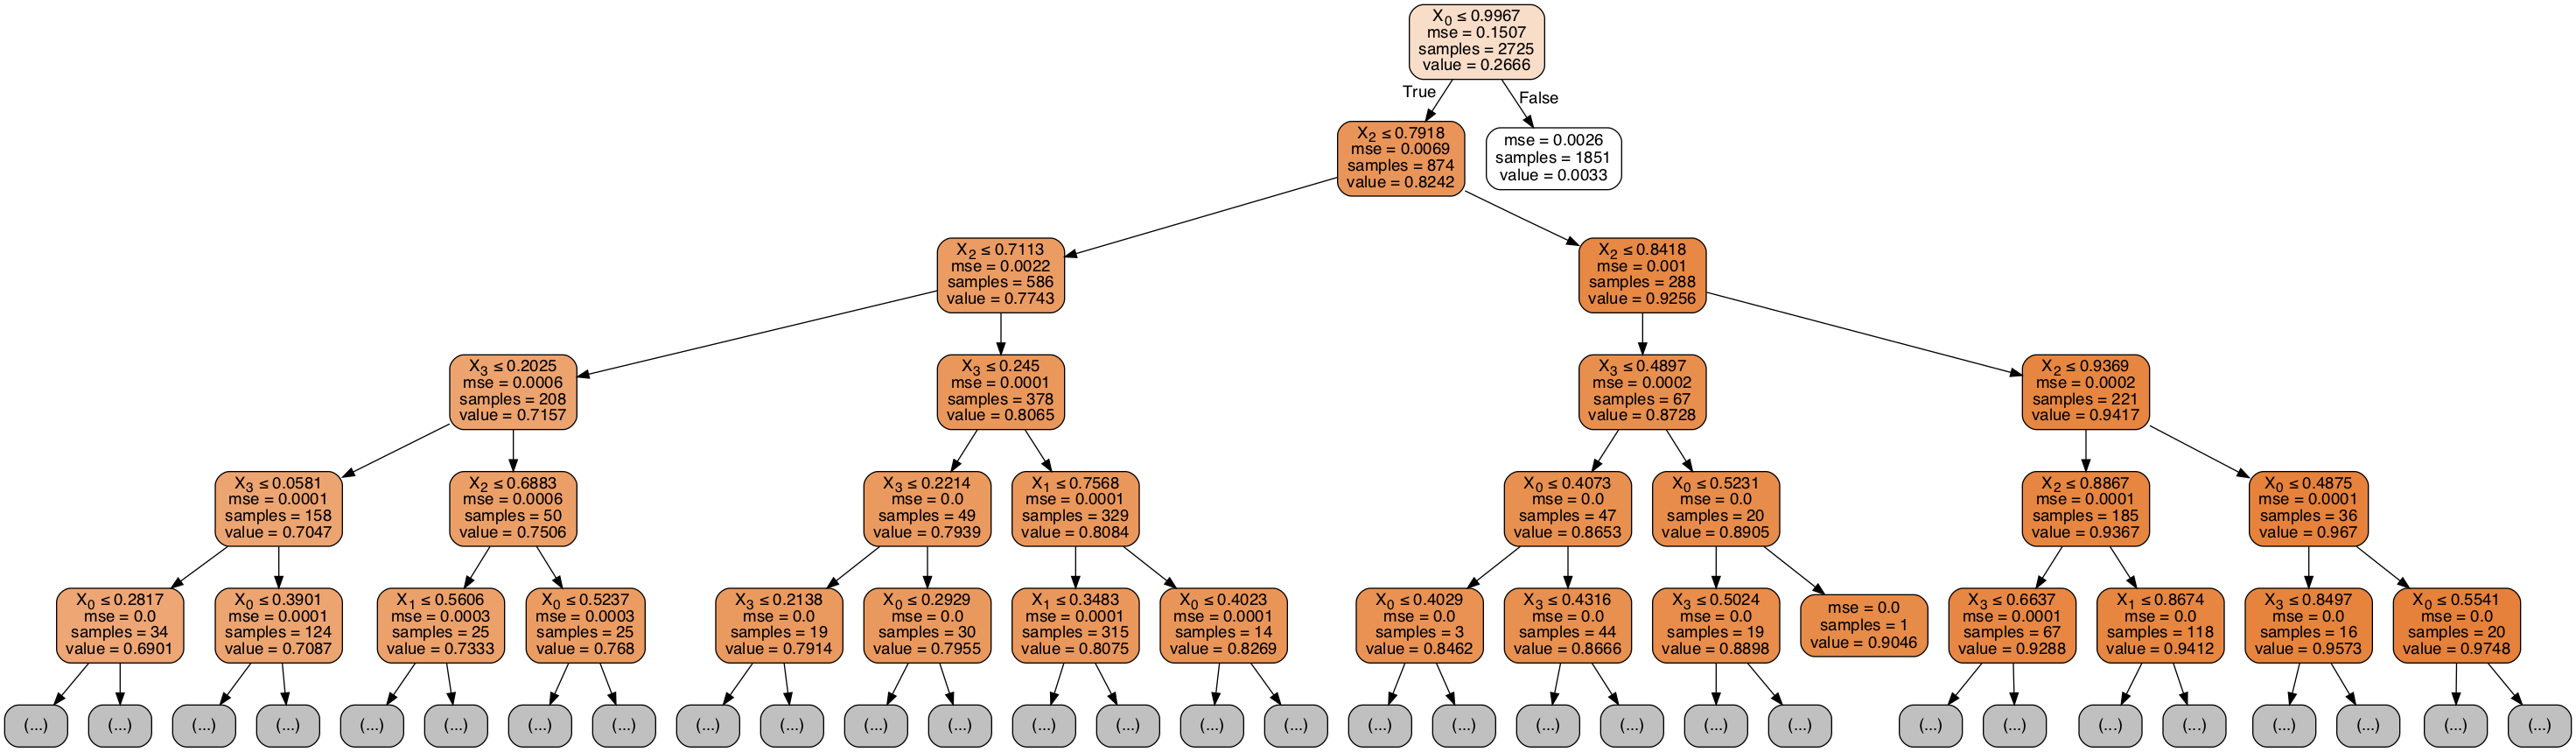

In [148]:
#decision tree models 
def fitBTCDataDecisionTrees( dataset, y_df ): 
    print("******************************BTC Dec Tree ******************************")
    #Create dataset
    btc_columns = ["Date", "Bitcoin Difficulty", "Bitcoin Hashrate", "Bitcoin Mining Prob",]
    btc_df = dataset[ btc_columns ].fillna(value = 0)
    btc_df.set_index("Date", inplace = True) 
    y_btc_df = y_df[ ["Bitcoin Market Cap"] ] 

    #Normalize data
    btc_df["Bitcoin Mining Prob"]=((btc_df["Bitcoin Mining Prob"]-btc_df["Bitcoin Mining Prob"].min())/(btc_df["Bitcoin Mining Prob"].max()-btc_df["Bitcoin Mining Prob"].min()))
    btc_df["Bitcoin Hashrate"]=((btc_df["Bitcoin Hashrate"]-btc_df["Bitcoin Hashrate"].min())/(btc_df["Bitcoin Hashrate"].max()-btc_df["Bitcoin Hashrate"].min()))
    btc_df["Bitcoin Difficulty"]=((btc_df["Bitcoin Difficulty"]-btc_df["Bitcoin Difficulty"].min())/(btc_df["Bitcoin Difficulty"].max()-btc_df["Bitcoin Difficulty"].min()))
    y_btc_df["Bitcoin Market Cap"]=((y_btc_df["Bitcoin Market Cap"]-y_btc_df["Bitcoin Market Cap"].min())/(y_btc_df["Bitcoin Market Cap"].max()-y_btc_df["Bitcoin Market Cap"].min()))
    
    #Training data set
    trainingX_btc_df = btc_df.loc[:date(year=2017,month=12,day=31)]
    trainingY_btc_df = y_btc_df.loc[:date(year=2017,month=12,day=31)]
    train = pd.concat([trainingX_btc_df, trainingY_btc_df], axis=1, join = "inner")

    #Run decision tree regressor on training set and print score
    decision_tree = DecisionTreeRegressor().fit( train[train.columns.tolist()[:-1]], train['Bitcoin Market Cap'])
    score = decision_tree.score(train[train.columns.tolist()[:-1]], train['Bitcoin Market Cap'])
    print("The fit of this BTC data with a Decision Trees model is %f" % score)

    #Create prediction data set 
    predictX_btc_df = btc_df.loc[date(year=2018, month=1, day =1):]
    predictY_btc_df = y_btc_df.loc[date(year=2018,month=1,day=1):date(year=2018,month=11,day=27)]
    predictData = pd.concat([predictX_btc_df, predictY_btc_df], axis=1, join = "inner")

    #Use decision tree to test on prediction set     
    predictions = decision_tree.predict( predictData[ predictData.columns.tolist()[:-1] ] )

    #Print additional info and graph predicted values with actual values    
    actual = predictY_btc_df["Bitcoin Market Cap"].values.tolist()
    print("Bitcoin range %f" %  ( max(actual) - min(actual) ) )
    y_true_mean = predictY_btc_df["Bitcoin Market Cap"].mean()
    print( "R-squared of BTC running Decision Trees is %f" % r2_score( predictions, actual ) )
    print( "MSE of BTC running Decision Trees is %f" % MSE( predictions, actual ) )
    print( "\n" )
    myplot(actual, predictions)
    
    #Draw the decision tree
    dot_data = StringIO()
    export_graphviz(decision_tree, out_file=dot_data, max_depth=5,
    filled=True, rounded=True,
    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    display(Image(graph.create_png()))
    
def fitETHDataDecisionTrees( dataset, y_df ): 
    print("******************************ETH Dec Tree ******************************")
    #Create dataset
    eth_columns = ["Date", "Ethereum Mining Prob", "Ethereum Avg. Transaction Value", "Ethereum No. of Transactions","Ethereum Avg. Transaction Fee"]
    eth_df = dataset[ eth_columns ].fillna(value = 0)
    eth_df.set_index("Date", inplace = True) 
    y_eth_df = y_df[ ["Ethereum Market Cap"] ]
    
    #Normalize data
    eth_df["Ethereum Mining Prob"]=((eth_df["Ethereum Mining Prob"]-eth_df["Ethereum Mining Prob"].min())/(eth_df["Ethereum Mining Prob"].max()-eth_df["Ethereum Mining Prob"].min()))
    eth_df["Ethereum Avg. Transaction Value"]=((eth_df["Ethereum Avg. Transaction Value"]-eth_df["Ethereum Avg. Transaction Value"].min())/(eth_df["Ethereum Avg. Transaction Value"].max()-eth_df["Ethereum Avg. Transaction Value"].min()))
    eth_df["Ethereum No. of Transactions"]=((eth_df["Ethereum No. of Transactions"]-eth_df["Ethereum No. of Transactions"].min())/(eth_df["Ethereum No. of Transactions"].max()-eth_df["Ethereum No. of Transactions"].min()))
    eth_df["Ethereum Avg. Transaction Fee"]=((eth_df["Ethereum Avg. Transaction Fee"]-eth_df["Ethereum Avg. Transaction Fee"].min())/(eth_df["Ethereum Avg. Transaction Fee"].max()-eth_df["Ethereum Avg. Transaction Fee"].min()))
    y_eth_df["Ethereum Market Cap"]=((y_eth_df["Ethereum Market Cap"]-y_eth_df["Ethereum Market Cap"].min())/(y_eth_df["Ethereum Market Cap"].max()-y_eth_df["Ethereum Market Cap"].min()))

    #Training data set
    trainingX_eth_df = eth_df.loc[:date(year=2017,month=12,day=31)]
    trainingY_eth_df = y_eth_df.loc[:date(year=2017,month=12,day=31)]
    train = pd.concat([trainingX_eth_df, trainingY_eth_df], axis=1, join = "inner")
    
    #Run decision tree regressor on training set and print score    
    decision_tree = DecisionTreeRegressor().fit( train[train.columns.tolist()[:-1]], train['Ethereum Market Cap'])
    score = decision_tree.score(train[train.columns.tolist()[:-1]], train['Ethereum Market Cap'])
    print("The fit of this ETH data with a Decision Trees model is %f" % score)

    #Create prediction data set 
    predictX_eth_df = eth_df.loc[date(year=2018, month=1, day =1):]
    predictY_eth_df = y_eth_df.loc[date(year=2018,month=1,day=1):date(year=2018,month=11,day=27)]
    predictData = pd.concat([predictX_eth_df, predictY_eth_df], axis=1, join = "inner")

    #Use decision tree to test on prediction set     
    predictions = decision_tree.predict( predictData[ predictData.columns.tolist()[:-1] ] )

    #Print additional info and graph predicted values with actual values    
    actual = predictY_eth_df["Ethereum Market Cap"].values.tolist()
    y_true_mean = predictY_eth_df["Ethereum Market Cap"].mean()
    print( "R-squared of ETH running Decision Trees is %f" % r2_score( predictions, actual ) )
    print( "MSE of ETH running Decision Trees is %f" % MSE( predictions, actual ) )
    print( "\n" )
    myplot(actual, predictions)
    
    #Draw the decision tree
    dot_data = StringIO()
    export_graphviz(decision_tree, out_file=dot_data, max_depth=5,
    filled=True, rounded=True,
    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    display(Image(graph.create_png()))

def runDecisionTreeData(): 
    dataset, y_df = cleanData() 
    fitBTCDataDecisionTrees( dataset, y_df )
    fitETHDataDecisionTrees( dataset, y_df )
    
runDecisionTreeData()   

******************************BTC Quant Reg ******************************
                         QuantReg Regression Results                          
Dep. Variable:     Bitcoin Market Cap   Pseudo R-squared:               0.8969
Model:                       QuantReg   Bandwidth:                     0.09602
Method:                 Least Squares   Sparsity:                       0.7988
Date:                Mon, 10 Dec 2018   No. Observations:                 2725
Time:                        20:33:31   Df Residuals:                     2722
                                        Df Model:                            3
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Bitcoin Difficulty      0.7083      0.008     85.883      0.000         0.692     0.724
Bitcoin Hashrate        0.4521      0.003    179.288      0.000         0.447     0.457
Bitcoin Mining Prob 

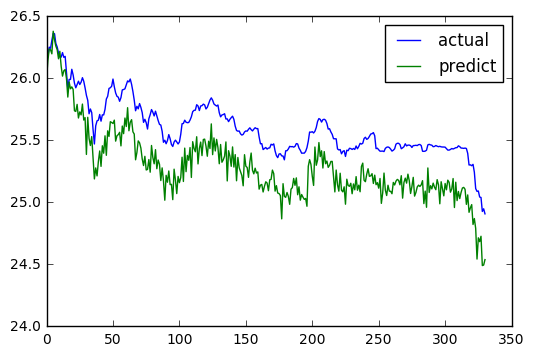

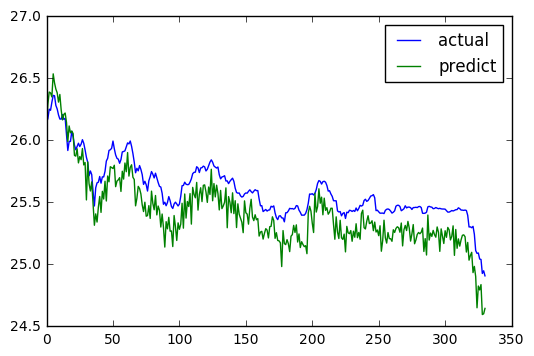

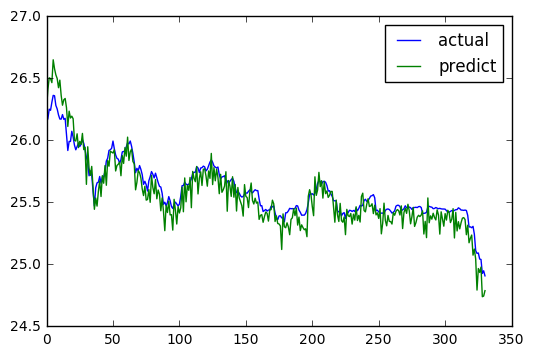

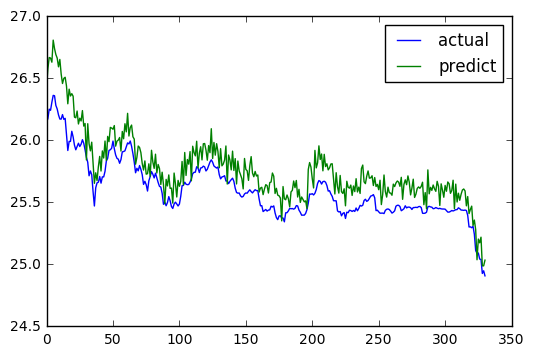

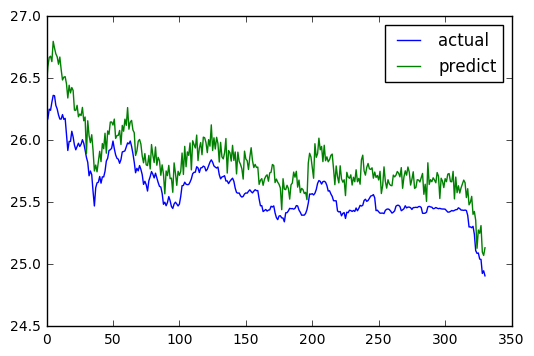

In [149]:
#quantile reg models
def fitBTCQuantRegression( dataset, y_df ): 
    print("******************************BTC Quant Reg ******************************")
    #Create dataset
    btc_columns = ["Date", "Bitcoin Difficulty", "Bitcoin Hashrate", "Bitcoin Mining Prob"]
    btc_df = dataset[ btc_columns ].fillna(value = 0)
    btc_df.set_index("Date", inplace = True) 
    y_btc_df = y_df[ ["Bitcoin Market Cap"] ] 
    
    #Training data set
    trainingX_btc_df = btc_df.loc[:date(year=2017,month=12,day=31)]
    trainingY_btc_df = y_btc_df.loc[:date(year=2017,month=12,day=31)]
    train = pd.concat([trainingX_btc_df, trainingY_btc_df], axis=1, join = "inner")
    
    #Run quantile regressor for different values of q and print summary when q=.6 (best fit)
    mod = smf.QuantReg(train.reset_index()['Bitcoin Market Cap'], train.reset_index()[ (train.reset_index()).columns.tolist()[1:-1]] )
    quant1 = mod.fit(q=.25)
    quant2 = mod.fit(q=.5)
    quant3 = mod.fit(q=.6)
    quant4 = mod.fit(q=.75)
    quant5 = mod.fit(q=.99)
    print(quant3.summary())
    
    #Create prediction dataset
    predictX_btc_df = btc_df.loc[date(year=2018, month=1, day =1):]
    predictY_btc_df = y_btc_df.loc[date(year=2018,month=1,day=1):date(year=2018,month=11,day=27)]
    predictData = pd.concat([predictX_btc_df, predictY_btc_df], axis=1, join = "inner")
    
    #Use quantile regressor to predict data
    predictions1 = quant1.predict( predictData[ predictData.columns.tolist()[:-1] ])
    predictions2 = quant2.predict( predictData[ predictData.columns.tolist()[:-1] ])
    predictions3 = quant3.predict( predictData[ predictData.columns.tolist()[:-1] ])
    predictions4 = quant4.predict( predictData[ predictData.columns.tolist()[:-1] ])
    predictions5 = quant5.predict( predictData[ predictData.columns.tolist()[:-1] ])

    #Print additional info and graph predicted values with actual values    
    actual = predictY_btc_df["Bitcoin Market Cap"].values.tolist()
    print("Bitcoin range %f" %  ( max(actual) - min(actual) ) )
    y_true_mean = predictY_btc_df["Bitcoin Market Cap"].mean()
    print( "R-squared of BTC running Quantile Regression is %f" % r2_score( predictions3, actual ) )
    print( "MSE of BTC running Quantile is %f" % MSE( predictions3, actual ) )
    print( "\n" )
    myplot(actual, predictions1)
    myplot(actual, predictions2)
    myplot(actual, predictions3)
    myplot(actual, predictions4)
    myplot(actual, predictions5)  
    
def fitETHQuantRegression( dataset, y_df ):
    print("******************************ETH Quant Reg ******************************")
    
    #creating a dataframe with all Ethereum data, got rid of Hashrate and # of transactions
    eth_columns = ["Date", "Ethereum Hashrate", "Ethereum Mining Prob", "Ethereum No. of Transactions","Ethereum Avg. Transaction Fee"]
    eth_df = dataset[ eth_columns ].fillna(value = 0)
    eth_df.set_index("Date", inplace = True) 
    y_eth_df = y_df[ ["Ethereum Market Cap"] ]

    #Training data set
    trainingX_eth_df = eth_df.loc[date(year=2011,month=12,day=31):date(year=2017,month=12,day=31)]
    trainingY_eth_df = y_eth_df.loc[date(year=2011,month=12,day=31):date(year=2017,month=12,day=31)]
    train = pd.concat([trainingX_eth_df, trainingY_eth_df], axis=1, join = "inner")
    print(train)
    
    #Run quantile regressor for different values of q and print summary when q=.6 (best fit)
    mod = smf.QuantReg(train["Ethereum Market Cap"], train[train.columns.tolist()[1:-1]] )
    print(mod)
    quant1 = mod.fit(q=.25)
    quant2 = mod.fit(q=.5)
    quant3 = mod.fit(q=.6)
    quant4 = mod.fit(q=.75)
    quant5 = mod.fit(q=.99)
    print(quant3.summary())
    
    #Create prediction dataset
    predictX_eth_df = eth_df.loc[date(year=2018, month=1, day =1):]
    predictY_eth_df = y_eth_df.loc[date(year=2018,month=1,day=1):date(year=2018,month=11,day=27)]
    predictData = pd.concat([predictX_btc_df, predictY_btc_df], axis=1, join = "inner")
    
    #Use quantile regressor to predict data
    predictions1 = quant1.predict( predictData[ predictData.columns.tolist()[:-1] ])
    predictions2 = quant2.predict( predictData[ predictData.columns.tolist()[:-1] ])
    predictions3 = quant3.predict( predictData[ predictData.columns.tolist()[:-1] ])
    predictions4 = quant4.predict( predictData[ predictData.columns.tolist()[:-1] ])
    predictions5 = quant5.predict( predictData[ predictData.columns.tolist()[:-1] ])

    #Print additional info and graph predicted values with actual values    
    actual = predictY_btc_df["Ethereum Market Cap"].values.tolist()
    print("Ethereum range %f" %  ( max(actual) - min(actual) ) )
    y_true_mean = predictY_btc_df["Ethereum Market Cap"].mean()
    print( "R-squared of ETH running Quantile Regression is %f" % r2_score( predictions3, actual ) )
    print( "MSE of ETH running Quantile is %f" % MSE( predictions3, actual ) )
    print( "\n" )
    #myplot(actual, predictions1)
    myplot(actual, predictions2)
    myplot(actual, predictions3)
    myplot(actual, predictions4)
    myplot(actual, predictions5)  
    
def runQuantReg(): 
    dataset, y_df = cleanData() 
    fitBTCQuantRegression( dataset, y_df )
    #fitETHQuantRegression( dataset, y_df )
    
runQuantReg()